In [8]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import umap
import shap
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [9]:
#ml imports
from tune_sklearn import TuneSearchCV
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
#tensorflow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [10]:
df = pd.read_csv('.\\data\\train.csv')

In [11]:
df_test = pd.read_csv('.\\data\\test.csv')

In [12]:
file = open('.//data/data_description.txt', 'r')

In [13]:
with open('.//data/data_description.txt') as file:
    text_data = file.readlines()
for temp in text_data:
    print(temp.strip())

MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.

A	Agriculture
C	Commercial
FV	Floating Village Residential
I	Industrial
RH	Residential High Density
RL	Residential Low Density
RP	Residential Low Density Park
RM	Residential Medium Density

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

Grvl	Gravel
Pave	Pave

In [14]:
#similar sounding column names to later compare/columns to possibly combine to avoid collinearity:
#Condition1, Condition2
#OverallQual, OverallCond
#YearBuilt,YearRemodAdd
#Exterior1st, Exterior2nd
#ExterQual, ExterCond
#BsmtFinSF1, BsmtFinType2, BsmntUnfSF, TotalBsmtSF
#BsmtFullBath, BsmtHalfBath
#FullBath, HalfBath
#All of the number and quality columns
#GarageCars, GarageArea
#GarageQual, GarageCond
#WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch
#MiscFeature, MiscVal

# Data Exploration
The label is the SalePrice column

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [16]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


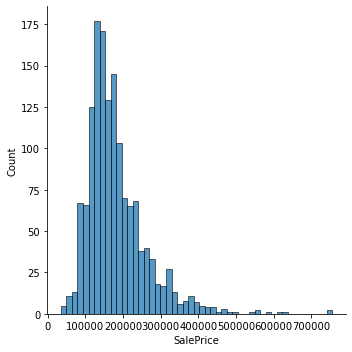

In [17]:
#Distribution plot of label, appears to be normally distributed
sns.displot(data=df,x='SalePrice')

In [18]:
#Correlation with label
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [19]:
#check value_counts() of dimensions

OverallQual column: Rates the overal material and finish of the house
GrLivArea: Above grade (ground) living area square feet
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet


<AxesSubplot:>

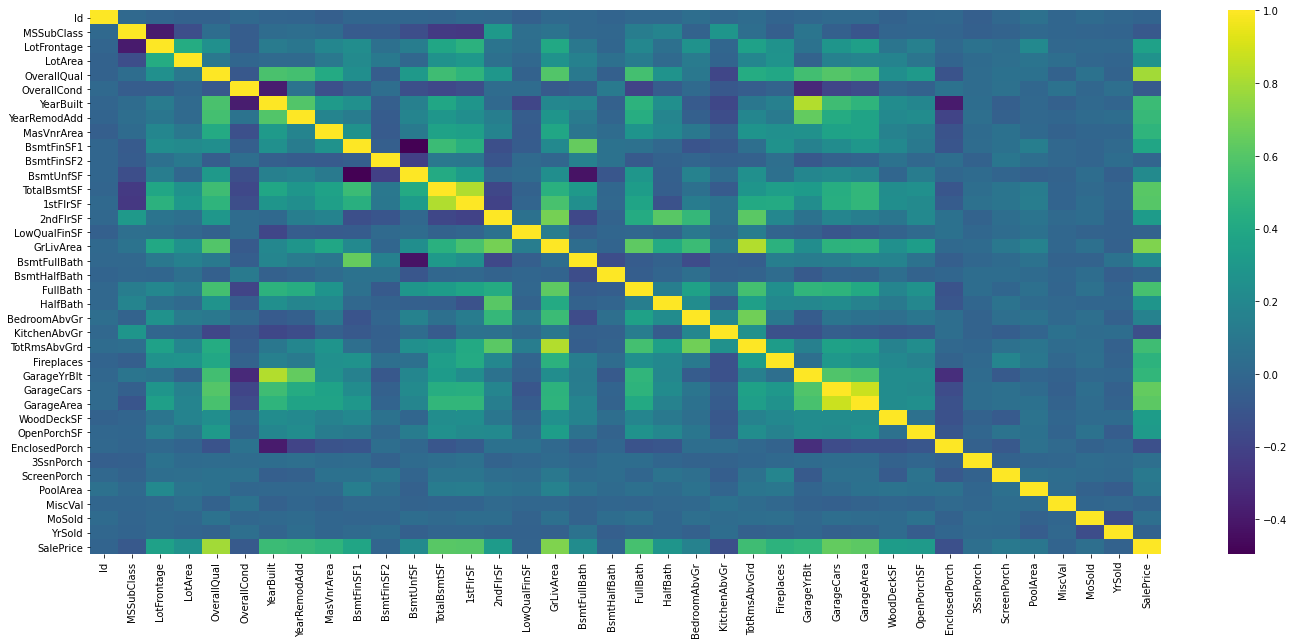

In [20]:
plt.figure(figsize=(24,10))
sns.heatmap(data=df.corr(),cmap='viridis')

We can try predicting based on a manual selection on some of these dimensions or we can use Principal Component Analysis to reduce the dimensionality of this data set and eliminate multicollinearity among the predictor variables. We'll try reducing the dimensions first

<AxesSubplot:>

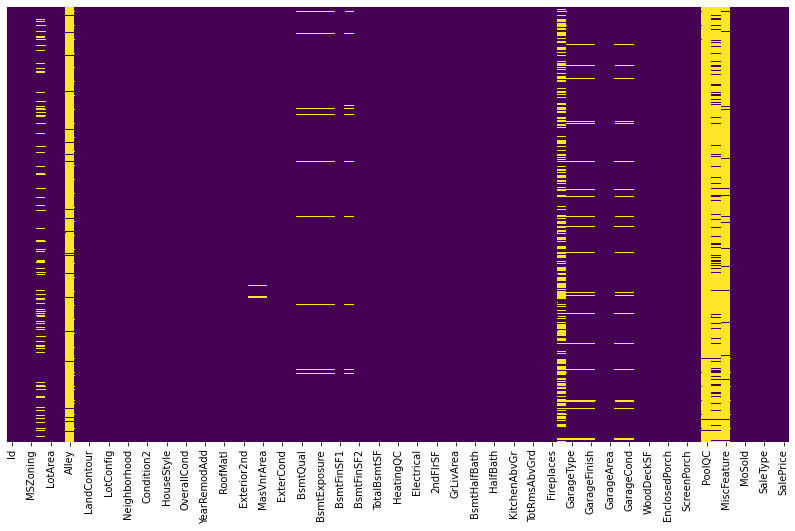

In [21]:
#Alley, PoolQC, Fence, MiscFeature are mostly empty. We can turn them into binary labels,
#or drop them completely.
plt.figure(figsize=(14,8))
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

# Data Preprocessing

In [22]:
#Alley
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [23]:
df['Alley'] = df['Alley'].fillna(value='None')

In [24]:
#PoolQC, only 7 values so I will drop
df['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [25]:
df.drop(columns='PoolQC',axis=1,inplace=True)

In [26]:
#Fence
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [27]:
#fillna for fence
df['Fence'] = df['Fence'].fillna(value='None')

In [28]:
#MiscFeature, less than 5 percent are filled, and shed does not seem like it would matter 
#while the value of the tennis court house likely has other dimensions that will account for it
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [29]:
df.drop(columns='MiscFeature',axis=1,inplace=True)

In [30]:
#Fireplaces is probably good enough without the fireplace quality column so we will drop it
df['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [31]:
df.drop(columns='FireplaceQu',axis=1,inplace=True)

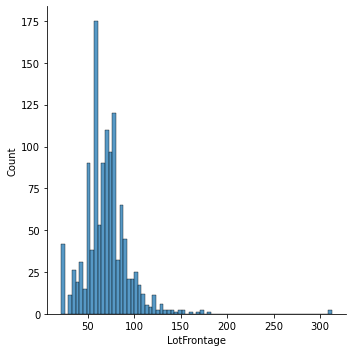

In [32]:
#LotFrontage
sns.displot(data=df,x='LotFrontage')

In [33]:
#fillna of LotFrontage, replace with 0
df['LotFrontage'] = df['LotFrontage'].fillna(value=0)

In [34]:
df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
df = pd.get_dummies(data=df,columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'], drop_first=True)

In [36]:
#quick drop of remaining NA rows, they represent less than 10% of data
df.dropna(inplace=True)

In [37]:
#remove label and Id column from PCA
df_pca = df.drop(labels='SalePrice',axis=1)

In [38]:
#standardize, fit, transform data
scaler = StandardScaler()

In [39]:
x_pca = scaler.fit_transform(df_pca)

In [40]:
#PCA with 20 components, roughly 10% of the original number of dimensions
pca = PCA(n_components=50)

In [41]:
pca.fit(x_pca)

PCA(n_components=50)

In [42]:
#transform into 20 principal components
x_pca = pca.transform(x_pca)

In [43]:
x_pca.shape

(1371, 50)

In [44]:
pca.components_

array([[-0.00372184,  0.00645907,  0.03809137, ..., -0.01241643,
        -0.06089339,  0.1120345 ],
       [-0.0024104 ,  0.11848952, -0.00110595, ..., -0.00284745,
        -0.03972661,  0.0600658 ],
       [ 0.00241734, -0.02792121,  0.09750796, ...,  0.01132408,
        -0.02159966,  0.01301722],
       ...,
       [ 0.09036521,  0.01504064,  0.04131508, ...,  0.01911299,
         0.0157787 ,  0.01079158],
       [-0.13287861, -0.06691224,  0.04221225, ...,  0.06749819,
         0.05936651, -0.05733021],
       [-0.10042809,  0.01354813,  0.00830454, ...,  0.00554321,
         0.02130562, -0.00751791]])

In [45]:
x_pca = pd.DataFrame(pca.components_,columns=df_pca.columns)

<AxesSubplot:>

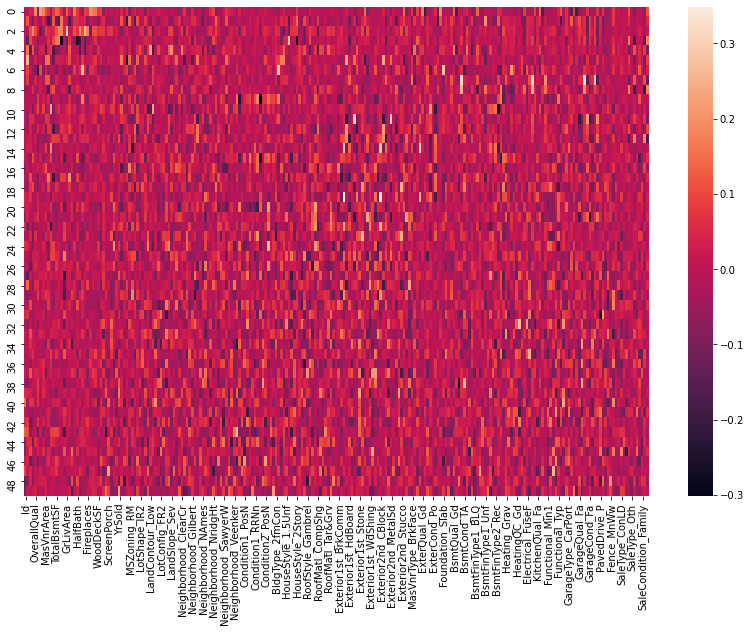

In [46]:
plt.figure(figsize=(14,9))
sns.heatmap(x_pca)

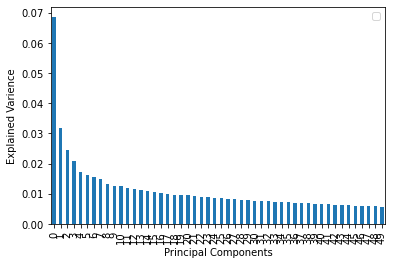

In [47]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience');

In [48]:
#
#We can run build a simple prediction model on this first component and check our results 
pca.explained_variance_ratio_[0]
#x_pca[:1].stack().sort_values(ascending=False)

0.06859459754544382

The explained variance by the first principal vector is very low, so I will try to select features based on feature importance using a random forest regressor

In [49]:
rf = RandomForestRegressor(max_depth=20)

# The Data used for model training below.   
X will be all the dimensions  
y will be the label  
X_df is the scaled labels  

In [50]:
#need train test split, or a seperate variable to fit transform the label but not fit it
X = df.drop(labels=['SalePrice','Id'],axis=1)
y = df['SalePrice']
X_df = scaler.fit_transform(df.drop(labels=['SalePrice','Id'],axis=1))

In [51]:
rf.fit(X_df,y)

RandomForestRegressor(max_depth=20)

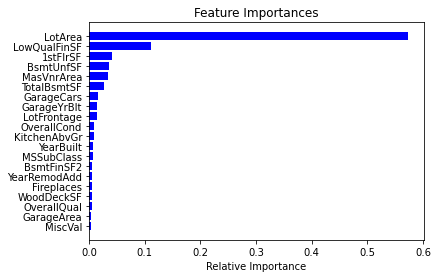

In [52]:
features = df.drop(labels='SalePrice',axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [53]:
np.corrcoef(x=df['OverallQual'],y=df['GrLivArea'])

array([[1.        , 0.59123769],
       [0.59123769, 1.        ]])

In [54]:
np.corrcoef(x=df['TotalBsmtSF'],y=df['BsmtFinSF1'])

array([[1.        , 0.51950515],
       [0.51950515, 1.        ]])

In [55]:
features = SelectFromModel(rf)

In [56]:
Fit = features.fit_transform(X_df,y)

In [57]:
print(Fit)

[[ 0.20624289 -0.21883609  0.6096228  ...  0.20695951  0.25614651
   0.21560696]
 [ 0.63470891 -0.10632348 -0.1346273  ...  0.20695951 -0.21729719
  -0.72343197]
 [ 0.2919361   0.05510767  0.6096228  ...  0.20695951  0.57894903
  -0.07688058]
 ...
 [ 0.23480729 -0.16091655  0.6096228  ... -1.37818849 -1.33634592
   0.20021288]
 [ 0.2919361  -0.09487654 -0.8788774  ... -1.37818849 -1.40090643
  -0.72343197]
 [ 0.4918869  -0.07335239 -0.8788774  ... -1.37818849 -1.20722491
   0.32336552]]


In [58]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [59]:
#Test regression models
models = []
models.append(('LinR', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(max_depth=30)))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('XGR', XGBRegressor()))
models.append(('DT', DecisionTreeRegressor()))

LinR: 0.636931 (0.369156)
SVR: -0.050942 (0.028558)
KNR: 0.640661 (0.069700)
RF: 0.848738 (0.073169)
GBR: 0.885739 (0.064500)
XGR: 0.839867 (0.101170)
DT: 0.720478 (0.051870)


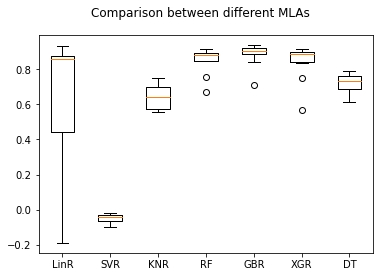

In [60]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparison between different MLAs')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Testing the best hyperparameters for RandomForestRegressor

In [61]:
#The RandomForestRegressor seems to be the best choice of algorithm along with GradientBoost
#We will use RandomizedSearchCV to find the best hyperparameters

#number of trees
n_estimators = [100,200,300,400,500,1000]

#max number of features at every split
max_features = ['auto','sqrt','log2']

#max levels in tree
max_depth=[10,20,30,40,50]
max_depth.append(None)

#min number of samples required to split a node
min_samples_split = [2,5,10,15,20]

#min samples per leaf
min_samples_leaf = [1,2,5,10,15]

#dictionary of parameters
grid_param = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

In [62]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [63]:
#rf_random.fit(X, y)
#print(rf_random.best_params_)

In [64]:
#result: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40}

Testing the best hyperparameters for GradientBoostingRegressor

In [65]:
#number of trees
n_estimators = [100,200,300]

#max levels in a tree
max_depth=[1,2,3,4,8,10,20,30]
max_depth.append(None)

#learning rates
learning_rate = [0.01,0.1,1,10]

#min number of samples required to split a node
min_samples_split = [2,5,10,15]

#min samples per leaf
min_samples_leaf = [1,2,3,4,5]

grid_param = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'learning_rate': learning_rate,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

In [66]:
gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator=gbr,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [67]:
#gbr_random.fit(X,y)
#print(gbr_random.best_params_)

In [68]:
#best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.1}

Testing the best hyperparameters for XGBRegressor

In [69]:
#number of trees
n_estimators = [100,200,300,400]

#max levels in a tree
max_depth=[1,2,3,4,8,10]
max_depth.append(None)

#min child weight
min_child_weight = [1,3,5,7]

#learning rates
learning_rate = [0.01,.05,0.1,.5,1]

#gamma
gamma = [0.0,0.1,0.2,0.3,0.4,0.5]

#colsample
colsample_bytree = [.3,.4,.5,.6,.7]


grid_param = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'min_child_weight': min_child_weight,
             'learning_rate': learning_rate,
             'gamma': gamma,
             'colsample_bytree': colsample_bytree}

In [70]:
xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgb,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [71]:
#xgb_random.fit(X,y)
#print(xgb_random.best_params_)

In [72]:
#best params 1: {'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3}
#best params 2: {'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.3}

In [73]:
#RF shap
rf = RandomForestRegressor(n_estimators= 200, min_samples_split= 2, min_samples_leaf= 1, 
                           max_features= 'auto', max_depth= 40)

In [74]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, n_estimators=200)

In [75]:
score = rf.score(X_test,y_test)
print(score)

0.8821495137394373


In [76]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

In [77]:
#df.corr()['SalePrice'].sort_values(ascending=False)

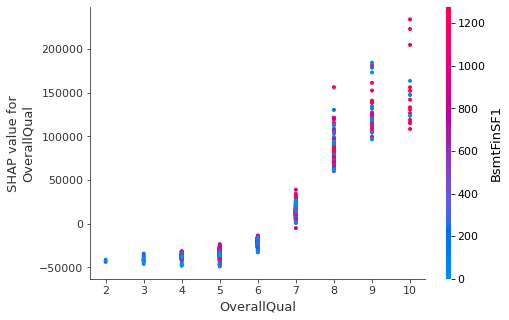

In [78]:
shap.dependence_plot(ind='OverallQual', shap_values=shap_values, features=X,interaction_index='BsmtFinSF1')

In [79]:
#Top 20 features by impact on model output are listed below
#shap.summary_plot(shap_values, X,max_display=40)

In [80]:
shap_vals_rf = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [81]:
shap_scores_rf = np.mean(shap_vals_rf).sort_values(ascending=False)

In [82]:
#train model on features up to the GarageQual_Gd label
rf_labels = shap_scores_rf[shap_scores_rf.values > 20]

In [83]:
rf_labels.index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageCars',
       '1stFlrSF', 'YearBuilt', 'LotArea', 'GarageArea', 'YearRemodAdd',
       '2ndFlrSF', 'Fireplaces', 'GarageFinish_Unf', 'OverallCond', 'FullBath',
       'OpenPorchSF', 'GarageType_Detchd', 'WoodDeckSF', 'GarageYrBlt',
       'BsmtQual_Gd', 'MasVnrArea', 'TotRmsAbvGrd', 'BsmtUnfSF', 'LotFrontage',
       'MSZoning_RM', 'MoSold', 'CentralAir_Y', 'LotShape_Reg', 'ExterQual_TA',
       'MSZoning_RL', 'GarageType_Attchd', 'HalfBath', 'BsmtFullBath',
       'KitchenQual_TA', 'KitchenQual_Gd', 'BsmtExposure_Gd', 'MSSubClass',
       'BsmtExposure_No', 'BsmtQual_TA', 'Exterior2nd_VinylSd',
       'BsmtFinType1_GLQ', 'Foundation_PConc', 'ExterQual_Gd', 'ScreenPorch',
       'HeatingQC_TA', 'YrSold', 'KitchenAbvGr', 'Functional_Typ',
       'SaleType_WD', 'SaleCondition_Normal', 'MasVnrType_Stone',
       'BedroomAbvGr', 'GarageFinish_RFn', 'Neighborhood_OldTown',
       'EnclosedPorch', 'Neighborhood_Crawfor', 

In [84]:
rf_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
       'YearBuilt', 'GarageArea', 'LotArea', 'GarageCars', 'YearRemodAdd',
       '2ndFlrSF', 'Fireplaces', 'FullBath', 'OverallCond', 'GarageFinish_Unf',
       'OpenPorchSF', 'GarageYrBlt', 'GarageType_Detchd', 'WoodDeckSF',
       'TotRmsAbvGrd', 'BsmtQual_Gd', 'MasVnrArea', 'BsmtUnfSF',
       'GarageType_Attchd', 'LotFrontage', 'ExterQual_TA', 'CentralAir_Y',
       'MoSold', 'MSZoning_RL', 'LotShape_Reg', 'MSSubClass', 'HalfBath',
       'MSZoning_RM', 'BsmtFullBath', 'BsmtExposure_Gd', 'BsmtExposure_No',
       'Foundation_PConc', 'KitchenQual_Gd', 'KitchenQual_TA',
       'Exterior2nd_VinylSd', 'BsmtFinType1_GLQ', 'BsmtQual_TA', 'ScreenPorch',
       'YrSold', 'BedroomAbvGr', 'SaleType_WD', 'Neighborhood_OldTown',
       'GarageFinish_RFn', 'MasVnrType_Stone', 'EnclosedPorch',
       'Neighborhood_Crawfor', 'Functional_Typ', 'KitchenAbvGr',
       'ExterQual_Gd', 'HeatingQC_TA', 'SaleCondition_Normal',
       'Foundation_CBlock', 'BsmtFinType1_Unf', 'LotConfig_Inside',
       'SaleCondition_Family', 'BsmtCond_TA', 'BsmtFinSF2',
       'LotConfig_CulDSac', 'Neighborhood_Edwards', 'HouseStyle_1Story',
       'ExterCond_Fa', 'BsmtHalfBath', 'HeatingQC_Gd', 'Neighborhood_NridgHt',
       'MasVnrType_BrkFace', 'Condition1_Norm', 'RoofStyle_Gable', 'PoolArea',
       'Neighborhood_CollgCr', 'Fence_None', 'LotShape_IR2',
       'Neighborhood_NAmes', 'LandContour_Lvl', 'Neighborhood_StoneBr',
       'Exterior1st_Wd Sdng', 'Exterior1st_BrkFace', 'SaleType_New',
       'Neighborhood_Somerst', 'BsmtExposure_Mn', 'HouseStyle_2Story',
       'Exterior1st_VinylSd', 'MasVnrType_None', 'RoofStyle_Hip',
       'LandSlope_Mod', 'Exterior2nd_HdBoard', 'SaleCondition_Partial',
       'Exterior1st_Plywood', 'ExterCond_TA', 'GarageCond_TA',
       'Neighborhood_Sawyer', 'Exterior2nd_ImStucc', 'ExterCond_Gd',
       'Neighborhood_NWAmes', 'Fence_MnPrv']

In [85]:
top_20_rf = ['OverallQual','GrLivArea','TotalBsmtSF','BsmtFinSF1','1stFlrSF','YearBuilt','LotArea','GarageCars','GarageArea',
            '2ndFlrSF','YearRemodAdd','Fireplaces','OverallCond','FullBath','GarageFinish_Unf','OpenPorchSF','GarageYrBlt',
            'GarageType_Detchd','WoodDeckSF','TotRmsAbvGrd']

In [86]:
#gbr shap
gbr = GradientBoostingRegressor(n_estimators= 200, min_samples_split= 10, min_samples_leaf = 1, 
                                max_depth = 2, learning_rate= 0.1)

In [87]:
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, min_samples_split=10, n_estimators=200)

In [88]:
score = gbr.score(X_test,y_test)
print(score)

0.8972137339596229


In [89]:
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(X)

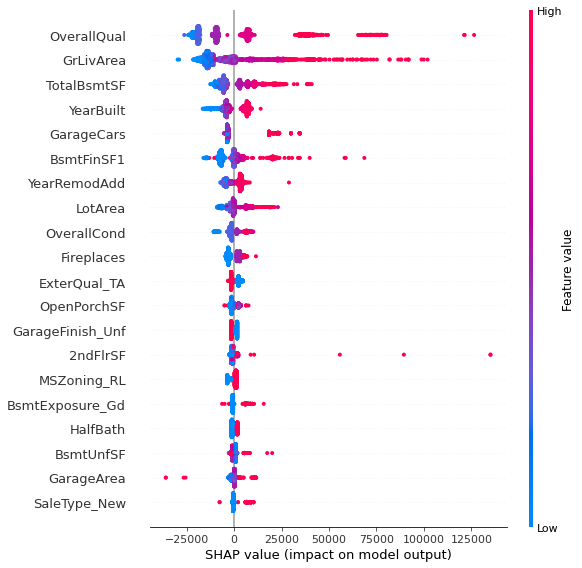

In [90]:
shap.summary_plot(shap_values, X)

Finding the best predictors for model

In [91]:
shap_vals_gb = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [92]:
shap_scores_gb = np.mean(shap_vals_gb).sort_values(ascending=False)

In [93]:
#getting predictors with shap score greater than 20
shap_scores_gb[shap_scores_gb.values > 20].index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageCars',
       'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'OverallCond', 'Fireplaces',
       'ExterQual_TA', 'OpenPorchSF', 'GarageFinish_Unf', '2ndFlrSF',
       'MSZoning_RL', 'BsmtExposure_Gd', 'HalfBath', 'BsmtUnfSF', 'GarageArea',
       'SaleType_New', 'KitchenQual_TA', 'WoodDeckSF', 'MoSold', 'GarageYrBlt',
       '1stFlrSF', 'ScreenPorch', 'Exterior1st_BrkFace',
       'SaleCondition_Normal', 'MasVnrArea', 'Neighborhood_Crawfor',
       'MSSubClass', 'SaleCondition_Partial', 'BsmtExposure_No',
       'Functional_Typ', 'Foundation_PConc', 'CentralAir_Y', 'MSZoning_RM',
       'LotShape_Reg', 'Condition1_Norm', 'Neighborhood_Somerst',
       'Neighborhood_Edwards', 'BsmtFinType1_GLQ', 'KitchenAbvGr',
       'Neighborhood_StoneBr', 'TotRmsAbvGrd', 'LotFrontage', 'FullBath',
       'BsmtFullBath', 'Condition1_RRAe', 'BedroomAbvGr',
       'Neighborhood_BrkSide', 'Neighborhood_NridgHt', 'PoolArea',
       'Neighborh

In [94]:
gbr_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt',
       'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'OverallCond', 'Fireplaces',
       'ExterQual_TA', 'OpenPorchSF', 'SaleCondition_Partial',
       'GarageFinish_Unf', '2ndFlrSF', 'MSZoning_RL', 'BsmtExposure_Gd',
       'HalfBath', 'BsmtUnfSF', 'GarageArea', 'KitchenQual_TA', 'WoodDeckSF',
       'MoSold', 'GarageYrBlt', '1stFlrSF', 'ScreenPorch',
       'Exterior1st_BrkFace', 'SaleCondition_Normal', 'MasVnrArea',
       'Neighborhood_Crawfor', 'MSSubClass', 'BsmtExposure_No',
       'Functional_Typ', 'Foundation_PConc', 'CentralAir_Y',
       'Neighborhood_Edwards', 'MSZoning_RM', 'LotShape_Reg',
       'Condition1_Norm', 'Neighborhood_Somerst', 'BsmtFinType1_GLQ',
       'KitchenAbvGr', 'Neighborhood_StoneBr', 'TotRmsAbvGrd', 'FullBath',
       'BsmtFullBath', 'SaleType_New', 'LotFrontage', 'Condition1_RRAe',
       'BedroomAbvGr', 'PoolArea', 'Neighborhood_BrkSide',
       'Neighborhood_NridgHt', 'Neighborhood_ClearCr', 'EnclosedPorch',
       'LotConfig_CulDSac', 'Functional_Mod', 'SaleCondition_Family',
       'BsmtFinSF2', 'Condition2_Norm', 'Functional_Sev', 'Condition2_PosN']

In [95]:
#xgb shap
xgb = XGBRegressor(n_estimators = 200, min_child_weight = 3, max_depth = 4, learning_rate = 0.1, 
                   gamma = 0.2, colsample_bytree = 0.3)

In [96]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [97]:
score = xgb.score(X_test,y_test)

In [98]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

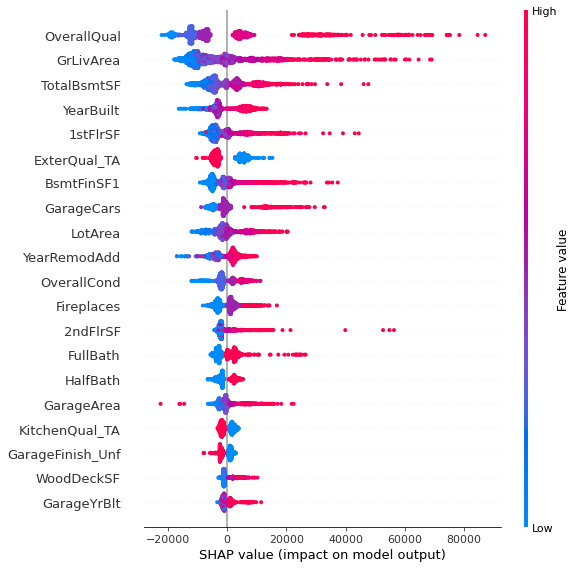

In [99]:
shap.summary_plot(shap_values, X, max_display=20)

In [100]:
print(score)

0.9030219168696704


In [101]:
#shap.dependence_plot(ind='GarageCars', shap_values=shap_values, features=X,interaction_index='GarageArea')

In [102]:
shap_vals_xgb = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [103]:
shap_scores_xgb = np.mean(shap_vals_xgb).sort_values(ascending=False)

In [104]:
shap_scores_xgb = shap_scores_xgb[shap_scores_xgb.values > 60]

In [105]:
#getting predictors with shap score greater than 20
shap_scores_xgb.index.values

array(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF',
       'ExterQual_TA', 'BsmtFinSF1', 'GarageCars', 'LotArea',
       'YearRemodAdd', 'OverallCond', 'Fireplaces', '2ndFlrSF',
       'FullBath', 'HalfBath', 'GarageArea', 'KitchenQual_TA',
       'GarageFinish_Unf', 'WoodDeckSF', 'GarageYrBlt', 'OpenPorchSF',
       'KitchenQual_Gd', 'MoSold', 'BsmtExposure_No', 'BsmtExposure_Gd',
       'SaleCondition_Normal', 'BsmtFullBath', 'TotRmsAbvGrd',
       'Foundation_CBlock', 'Functional_Typ', 'MSSubClass', 'ScreenPorch',
       'YrSold', 'Neighborhood_Crawfor', 'LotShape_Reg',
       'BsmtFinType1_GLQ', 'BsmtUnfSF', 'MSZoning_RL', 'MasVnrArea',
       'HouseStyle_2Story', 'SaleType_New', 'Condition1_Norm',
       'BsmtQual_Gd', 'Exterior1st_BrkFace', 'KitchenAbvGr',
       'Neighborhood_Somerst', 'LotFrontage', 'MSZoning_RM',
       'CentralAir_Y', 'GarageType_Attchd', 'Neighborhood_OldTown',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'Neighborhood_Edwards',
   

In [106]:
xgb_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF',
       'ExterQual_TA', 'BsmtFinSF1', 'GarageCars', 'LotArea',
       'YearRemodAdd', 'OverallCond', 'Fireplaces', '2ndFlrSF',
       'FullBath', 'HalfBath', 'GarageArea', 'KitchenQual_TA',
       'GarageFinish_Unf', 'WoodDeckSF', 'GarageYrBlt', 'OpenPorchSF',
       'KitchenQual_Gd', 'MoSold', 'BsmtExposure_No', 'BsmtExposure_Gd',
       'SaleCondition_Normal', 'BsmtFullBath', 'TotRmsAbvGrd',
       'Foundation_CBlock', 'Functional_Typ', 'MSSubClass', 'ScreenPorch',
       'YrSold', 'Neighborhood_Crawfor', 'LotShape_Reg',
       'BsmtFinType1_GLQ', 'BsmtUnfSF', 'MSZoning_RL', 'MasVnrArea',
       'HouseStyle_2Story', 'SaleType_New', 'Condition1_Norm',
       'BsmtQual_Gd', 'Exterior1st_BrkFace', 'KitchenAbvGr',
       'Neighborhood_Somerst', 'LotFrontage', 'MSZoning_RM',
       'CentralAir_Y', 'GarageType_Attchd', 'Neighborhood_OldTown',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'Neighborhood_Edwards',
       'BsmtHalfBath', 'Neighborhood_NridgHt', 'Neighborhood_BrkSide',
       'Foundation_PConc', 'BsmtFinType1_Unf', 'BedroomAbvGr',
       'LotConfig_FR2', 'BsmtFinSF2', 'PavedDrive_Y', 'LandContour_Lvl',
       'SaleCondition_Partial', 'Neighborhood_StoneBr', 'EnclosedPorch',
       'HouseStyle_1Story', 'GarageType_Detchd', 'ExterCond_TA',
       'Condition1_RRAe', 'HeatingQC_Gd', 'PoolArea', 'ExterQual_Gd',
       'Neighborhood_ClearCr', 'Exterior2nd_HdBoard',
       'Exterior1st_HdBoard', 'GarageQual_Gd', 'SaleType_WD',
       'GarageType_CarPort', 'Exterior1st_MetalSd', 'Neighborhood_NWAmes',
       'Exterior1st_VinylSd']

# Training Model on top 20 RF predictors

In [107]:
#top 20 predictor labels
X_rf = X[top_20_rf]
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.25, random_state=42)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)
print(metrics.mean_absolute_error(predictions,y_test))

17888.522755102043


In [108]:
#top 20 predictor labels
X_rf = X[top_20_rf]

In [109]:
df_test.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# Preprocessing of test dataset

In [110]:
#preprocessing

df_test['Alley'] = df_test['Alley'].fillna(value='None')
df_test.drop(columns='PoolQC', axis=1, inplace=True)
df_test['Fence'] = df_test['Fence'].fillna(value='None')
df_test.drop(columns='MiscFeature',axis=1,inplace=True)
df_test.drop(columns='FireplaceQu',axis=1,inplace=True)
df_test.drop(labels='Id',axis=1,inplace=True)

In [111]:
df_test.shape

(1459, 76)

In [112]:
df_test.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [113]:
#First get dummies from text columns
df_test = pd.get_dummies(data=df_test,columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'], drop_first=True)

In [114]:
df_test.shape

(1459, 222)

In [115]:
df_test_X = df_test[top_20_rf]

In [116]:
df_test_X.isna().sum()

OverallQual           0
GrLivArea             0
TotalBsmtSF           1
BsmtFinSF1            1
1stFlrSF              0
YearBuilt             0
LotArea               0
GarageCars            1
GarageArea            1
2ndFlrSF              0
YearRemodAdd          0
Fireplaces            0
OverallCond           0
FullBath              0
GarageFinish_Unf      0
OpenPorchSF           0
GarageYrBlt          78
GarageType_Detchd     0
WoodDeckSF            0
TotRmsAbvGrd          0
dtype: int64

In [117]:
#no basement
df_test_X[df_test['TotalBsmtSF'].isna()]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
660,4,896,NaN,NaN,896,1946,5940,1.0,280.0,0,1950,0,7,1,1,0,1946.0,1,0,4


In [118]:
#no garage
df_test_X[df_test['GarageCars'].isna()]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
1116,5,1828,859.0,548.0,942,1923,9060,NaN,NaN,886,1999,0,6,2,0,0,NaN,1,174,6


In [119]:
#no garage, except for 1 
df_test_X[df_test['GarageYrBlt'].isna()]['GarageArea'].value_counts()

0.0      76
360.0     1
Name: GarageArea, dtype: int64

In [120]:
df_test_X[(df_test['GarageYrBlt'].isna()) & (df_test['GarageArea'] == 360.0)]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
666,6,1984,1242.0,196.0,1242,1910,8094,1.0,360.0,742,1983,0,8,2,0,0,NaN,1,64,8


In [121]:
df_test_X.loc[df_test_X.index==666, 'GarageYrBlt'] = 1983


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
df_test_X.fillna(value=0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [123]:
df_test_X.head()

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
0,5,896,882.0,468.0,896,1961,11622,1.0,730.0,0,1961,0,6,1,1,0,1961.0,0,140,5
1,6,1329,1329.0,923.0,1329,1958,14267,1.0,312.0,0,1958,0,6,1,1,36,1958.0,0,393,6
2,5,1629,928.0,791.0,928,1997,13830,2.0,482.0,701,1998,1,5,2,0,34,1997.0,0,212,6
3,6,1604,926.0,602.0,926,1998,9978,2.0,470.0,678,1998,1,6,2,0,36,1998.0,0,360,7
4,8,1280,1280.0,263.0,1280,1992,5005,2.0,506.0,0,1992,0,5,2,0,82,1992.0,0,0,5


In [124]:
#it works, but not very accurate. I could try to train on a model that uses all fo the labels
predictions = rf.predict(df_test_X)

# RF on all labels

In [125]:
#preprocessing
df_test.isna().sum()


MSSubClass                 0
LotFrontage              227
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
YearRemodAdd               0
MasVnrArea                15
BsmtFinSF1                 1
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
GrLivArea                  0
BsmtFullBath               2
BsmtHalfBath               2
FullBath                   0
HalfBath                   0
BedroomAbvGr               0
KitchenAbvGr               0
TotRmsAbvGrd               0
Fireplaces                 0
GarageYrBlt               78
GarageCars                 1
GarageArea                 1
WoodDeckSF                 0
OpenPorchSF                0
EnclosedPorch              0
3SsnPorch                  0
ScreenPorch                0
PoolArea                   0
MiscVal                    0
MoSold        

In [126]:
df_test['PoolArea'].value_counts()

0      1453
144       1
228       1
368       1
444       1
561       1
800       1
Name: PoolArea, dtype: int64

In [127]:
#we can drop poolqc and fill every other na with 0 with the exception of the row we found earlier in the 
#20 feature rf model

In [128]:
df_test.loc[df_test_X.index==666, 'GarageYrBlt'] = 1983

In [129]:
df_test.fillna(value=0, inplace=True)

In [130]:
#train an rf model with the labels that match df_test
X_train, X_test, y_train, y_test = train_test_split(X[rf_labels], y, test_size=0.25, random_state=42)

In [131]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, n_estimators=200)

In [132]:
predictions = rf.predict(df_test[rf_labels])

Using the random forest regressor with the top 20 predictors according to shap values, the RMSLE was .15472
With the top 78 predictors, the improvement was minimal to .15330
The random forest regressor was the least accurate of three regressors I tried according to the initial comparison run, but there are changes I could make in data preprocessing and possibly in the hyper-parameter turning as well for a better score using this method.

# GradientBoosting Test

For the gradient boosting test I will need to check the variables for collinearity, something that random forests was good at eliminating naturally. I could try training a model on the same predictors first to see how effective it is. I can also do a test submission on the model without checking the variables for collinearity.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X[gbr_labels], y, test_size=0.25, random_state=42)

In [134]:
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, min_samples_split=10, n_estimators=200)

In [135]:
#predictions without checking for collinearity
predictions = gbr.predict(df_test[gbr_labels])

The submission without accounting for possibly collinear variables scored .14110, which is a good improvement over the random forest regressor. Next submission will refine the predictors used.

In [136]:
#X[gbr_labels].corr()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,YearBuilt,BsmtFinSF1,YearRemodAdd,LotArea,OverallCond,Fireplaces,ExterQual_TA,OpenPorchSF,SaleCondition_Partial,GarageFinish_Unf,2ndFlrSF,MSZoning_RL,BsmtExposure_Gd,HalfBath,BsmtUnfSF,GarageArea,KitchenQual_TA,WoodDeckSF,MoSold,GarageYrBlt,1stFlrSF,ScreenPorch,Exterior1st_BrkFace,SaleCondition_Normal,MasVnrArea,Neighborhood_Crawfor,MSSubClass,BsmtExposure_No,Functional_Typ,Foundation_PConc,CentralAir_Y,Neighborhood_Edwards,MSZoning_RM,LotShape_Reg,Condition1_Norm,Neighborhood_Somerst,BsmtFinType1_GLQ,KitchenAbvGr,Neighborhood_StoneBr,TotRmsAbvGrd,FullBath,BsmtFullBath,SaleType_New,LotFrontage,Condition1_RRAe,BedroomAbvGr,PoolArea,Neighborhood_BrkSide,Neighborhood_NridgHt,Neighborhood_ClearCr,EnclosedPorch,LotConfig_CulDSac,Functional_Mod,SaleCondition_Family,BsmtFinSF2,Condition2_Norm,Functional_Sev,Condition2_PosN
OverallQual,1.000000,0.591238,0.531361,0.580304,0.570995,0.220754,0.556807,0.090595,-0.135286,0.384095,-0.672251,0.313464,0.327112,-0.513222,0.289329,0.117595,0.209763,0.262916,0.320169,0.526372,-0.581029,0.229031,0.063142,0.546510,0.468264,0.052092,-0.034691,-0.161881,0.403120,0.014351,0.052093,-0.190794,0.162376,0.573256,0.224672,-0.176022,-0.193411,-0.204671,0.105558,0.220766,0.432670,-0.173905,0.200741,0.430270,0.558290,0.106344,0.331937,0.179029,-0.048617,0.086229,0.064900,-0.114244,0.370684,-0.026896,-0.105486,0.065867,-0.035578,-0.034491,-0.072132,-0.002525,-0.003637,0.108641
GrLivArea,0.591238,1.000000,0.441078,0.484027,0.195279,0.205896,0.279965,0.255225,-0.088940,0.461190,-0.387681,0.342621,0.164780,-0.299858,0.686231,0.131246,0.157278,0.414494,0.227155,0.479586,-0.356212,0.244547,0.052264,0.231484,0.554373,0.096622,0.032045,-0.093979,0.392325,0.091365,0.074842,-0.092294,-0.064769,0.287212,0.069141,-0.060416,-0.143218,-0.195726,-0.058641,0.033641,0.196966,0.083940,0.090764,0.820919,0.623147,0.035389,0.170491,0.220243,-0.033654,0.512306,0.175317,-0.091047,0.177561,0.056432,0.016953,0.068426,0.063479,-0.012281,-0.018932,-0.052648,0.044063,0.135965
TotalBsmtSF,0.531361,0.441078,1.000000,0.431786,0.378322,0.519505,0.284182,0.250440,-0.177966,0.330438,-0.394542,0.260425,0.263853,-0.353249,-0.194339,0.248260,0.295378,-0.075046,0.406701,0.490968,-0.320842,0.225786,0.006493,0.322695,0.821173,0.078074,0.042934,-0.163107,0.357466,-0.026799,-0.240887,-0.176275,0.053929,0.298962,0.181568,-0.076928,-0.230786,-0.184669,0.058244,0.034484,0.313418,-0.072723,0.140818,0.268315,0.310060,0.308101,0.263374,0.240627,-0.012716,0.024975,0.128458,-0.106173,0.291244,0.045459,-0.088005,0.063157,0.031127,0.016026,0.102041,-0.015802,-0.003217,0.134689
GarageCars,0.580304,0.484027,0.431786,1.000000,0.523288,0.200047,0.450254,0.137875,-0.246913,0.245357,-0.500192,0.242185,0.309570,-0.421484,0.187670,0.150418,0.193744,0.197224,0.244771,0.831217,-0.422920,0.205865,0.036147,0.589016,0.440001,0.016521,-0.053577,-0.183379,0.363550,-0.076925,0.012729,-0.239567,0.088799,0.472651,0.126880,-0.138842,-0.205456,-0.187030,0.044015,0.164044,0.336571,0.052165,0.114618,0.401335,0.512210,0.134522,0.315656,0.192495,-0.007307,0.119661,0.014087,-0.136707,0.302775,-0.012272,-0.147476,0.073991,-0.003611,-0.032679,-0.074681,-0.009521,0.005591,0.068498
YearBuilt,0.570995,0.195279,0.378322,0.523288,1.000000,0.229451,0.615966,-0.004377,-0.404732,0.116156,-0.604627,0.217322,0.348690,-0.615027,0.016472,0.254351,0.149715,0.233441,0.158429,0.444662,-0.476668,0.215198,0.005380,0.824669,0.260980,-0.068231,-0.113282,-0.176199,0.302720,-0.209160,0.060624,-0.238147,0.176276,0.664982,0.356066,-0.102416,-0.390544,-0.237905,0.183907,0.277680,0.478811,-0.163859,0.119151,0.103738,0.484524,0.180302,0.352303,0.034995,0.020914,-0.069537,0.001534,-0.278637,0.271127,-0.026427,-0.378045,0.106791,-0.058313,-0.044371,-0.065376,0.111017,-0.007184,0.044507
BsmtFinSF1,0.220754,0.205896,0.519505,0.200047,0.229451,1.000000,0.113870,0.209126,-0.046276,0.252195,-0.117543,0.116229,0.037444,-0.207765,-0.141519,0.197290,0.325847,-0.009932,-0.5038

# XGBoost Test

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X[xgb_labels], y, test_size=0.25, random_state=42)

In [138]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [139]:
predictions = xgb.predict(df_test[xgb_labels])

The predictions using XGBoost regressor without adjusting for collinearity scored .12896, which is a significant improvement over the Gradient Boost regressor unadjusted. The rest of my effort will be directed towards improving this model

# ML Model Test

In [140]:
#primary hyperparamters of neural networks
model_info = {}
model_info['Hidden layers'] = [100] * 6
model_info['Input size'] = og_one_hot.shape[1] - 1
model_info['Activations'] = ['relu'] * 6
model_info['Optimization'] = 'adadelta'
model_info["Learning rate"] = .005
model_info["Batch size"] = 32
model_info["Preprocessing"] = 'Standard'
model_info["Lambda"] = 0
model_2['Regularization'] = 'l2'
model_2['Reg param'] = 0.0005

NameError: name 'og_one_hot' is not defined